In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
from fairlearn.reductions import DemographicParity, ExponentiatedGradient, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer
import shap 

data = pd.read_csv("Assignment_dataset.csv")


In [12]:
# Exploratory Data Analysis

# Quick look at the dataset
print(data.head())
print("\nShape of the dataset:", data.shape)
print("\nData types of each column:")
print(data.dtypes)
print("\nMissing values in each column:")
print(data.isnull().sum())


  ASSIGNED_SUBJECT  NATURAL_SCIENCE_SCORE  ENGLISH_SCORE  READING_SCORE  \
0       Humanities                     61             55             69   
1             STEM                     59             56             60   
2             STEM                     61             55             59   
3             STEM                     76             86             71   
4       Humanities                     69             52             66   

   MATH_SCORE  SOCIAL_SCIENCE_SCORE SCHOOL_CALENDAR  PUBLIC_SCHOOL  \
0          68                    68               A           True   
1          48                    53               A           True   
2          54                    57               A           True   
3          84                    75               A          False   
4          61                    68               A           True   

   BILINGUAL_SCHOOL GENDER PARENTS_EDUCATION FAMILY_INCOME_LEVEL  \
0             False      M           Primary                

In [13]:
# Summary Statistics:
print("\nSummary statistics for numerical columns:")
print(data.describe())


Summary statistics for numerical columns:
       NATURAL_SCIENCE_SCORE  ENGLISH_SCORE  READING_SCORE    MATH_SCORE  \
count           63587.000000   63587.000000   63587.000000  63587.000000   
mean               62.992247      64.323887      63.124617     64.311840   
std                 8.023284      11.870841       7.535490      9.532562   
min                27.000000      26.000000      28.000000     24.000000   
25%                58.000000      56.000000      58.000000     58.000000   
50%                63.000000      63.000000      63.000000     64.000000   
75%                68.000000      73.000000      68.000000     70.000000   
max               100.000000     100.000000     100.000000    100.000000   

       SOCIAL_SCIENCE_SCORE  
count          63587.000000  
mean              62.896897  
std                8.308691  
min               23.000000  
25%               57.000000  
50%               63.000000  
75%               68.000000  
max              100.000000  


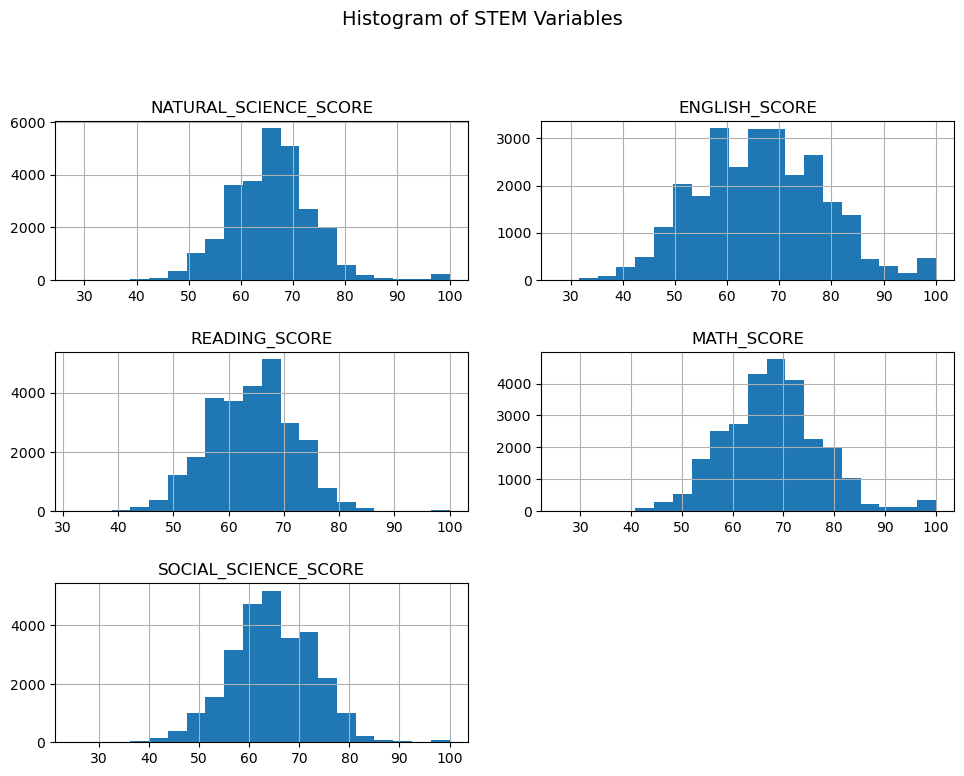

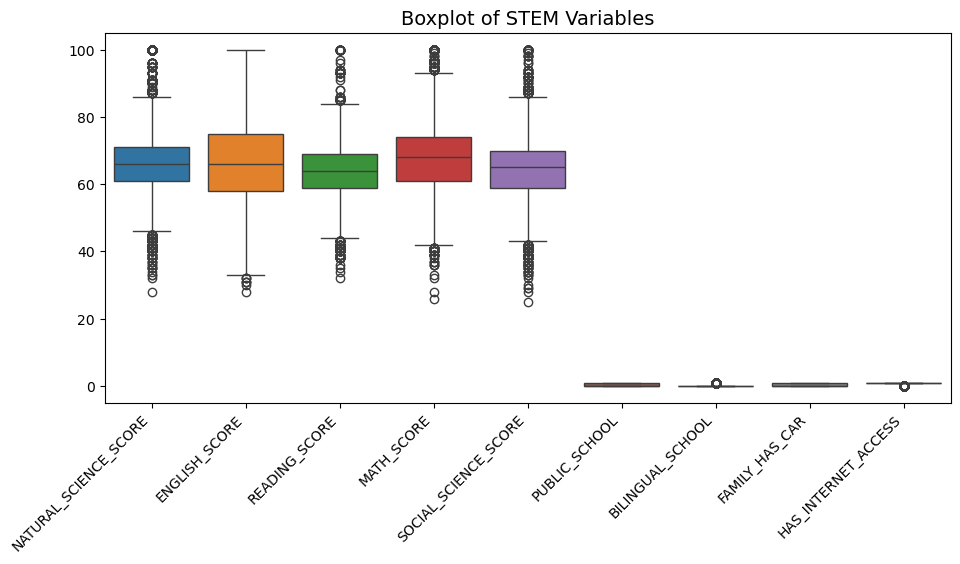

In [14]:
# Visual Exploratory Data Analysis for STEM:
stem_data = data[data["ASSIGNED_SUBJECT"] == "STEM"]
fig = stem_data.hist(figsize=(10, 8), bins=20) 
plt.suptitle('Histogram of STEM Variables', fontsize=14)


plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.96])  
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=stem_data)

plt.title('Boxplot of STEM Variables', fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout(pad=2.0)
plt.show()

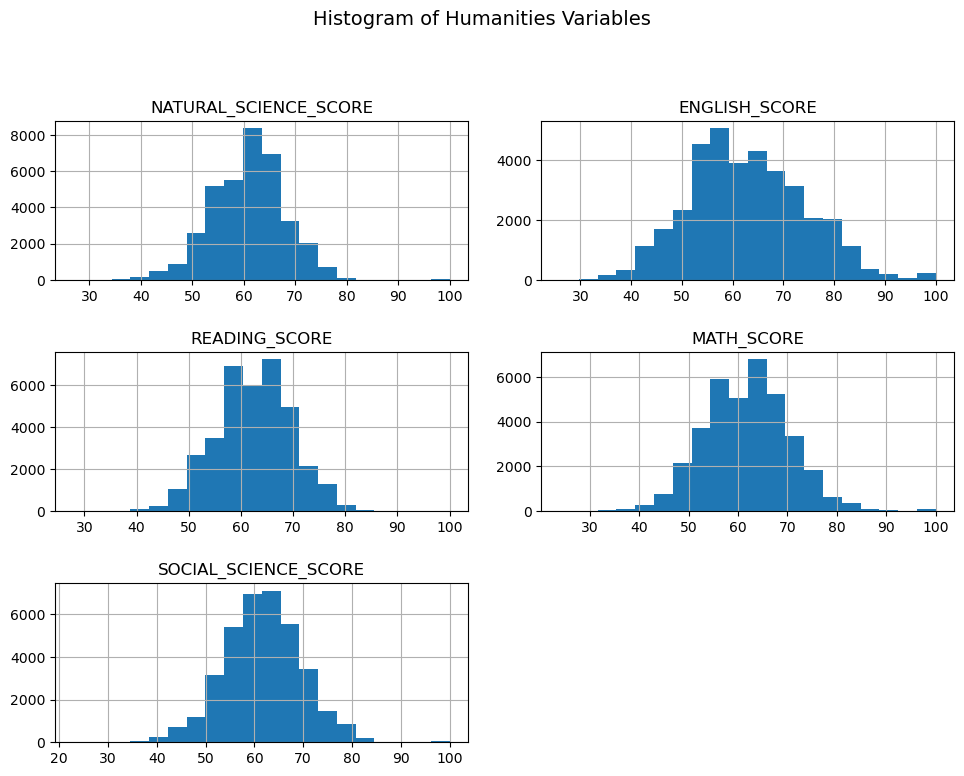

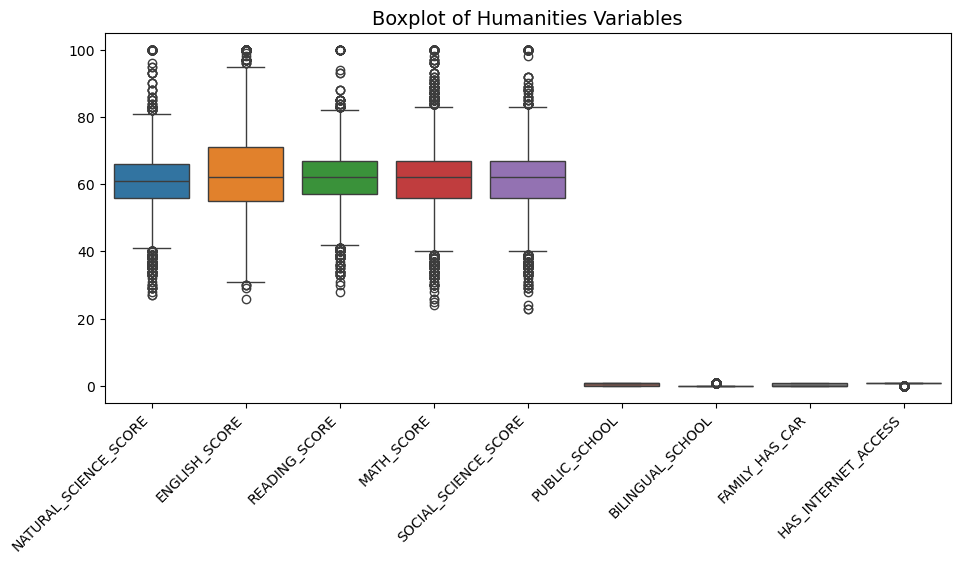

In [15]:
# Visual Exploratory Data Analysis for HUMANITIES:
human_data = data[data["ASSIGNED_SUBJECT"] == "Humanities"]
fig = human_data.hist(figsize=(10, 8), bins=20) 
plt.suptitle('Histogram of Humanities Variables', fontsize=14)


plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.96])  
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=human_data)

plt.title('Boxplot of Humanities Variables', fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout(pad=2.0)
plt.show()

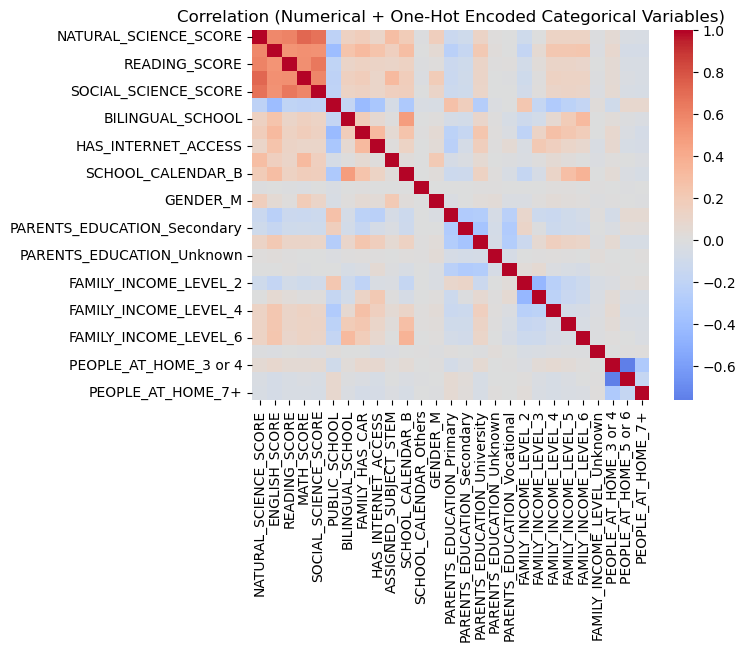

In [16]:
# Correlation analysis

#Firstly we need to use One-hot enconding on categorical data

encoded_data = pd.get_dummies(data, drop_first=True)

#Plot the heatmap
sns.heatmap(encoded_data.corr(), cmap="coolwarm", center=0)
plt.title("Correlation (Numerical + One-Hot Encoded Categorical Variables)")
plt.show()

In [17]:
print(encoded_data.tail())
print("\nShape of the dataset:", encoded_data.shape)
print("\nData types of each column:")
print(encoded_data.dtypes)
print("\nMissing values in each column:")
print(encoded_data.isnull().sum())

       NATURAL_SCIENCE_SCORE  ENGLISH_SCORE  READING_SCORE  MATH_SCORE  \
63582                     56             58             62          60   
63583                     53             57             59          60   
63584                     39             51             49          46   
63585                     56             54             67          62   
63586                     53             47             47          51   

       SOCIAL_SCIENCE_SCORE  PUBLIC_SCHOOL  BILINGUAL_SCHOOL  FAMILY_HAS_CAR  \
63582                    53           True             False            True   
63583                    45          False             False            True   
63584                    55           True             False            True   
63585                    66           True             False           False   
63586                    43           True             False           False   

       HAS_INTERNET_ACCESS  ASSIGNED_SUBJECT_STEM  ...  \
63582           

In [18]:
#Splitting the data
X = data.drop("ASSIGNED_SUBJECT", axis=1)
y = data["ASSIGNED_SUBJECT"]

X_dum = pd.get_dummies(X, drop_first=True)
y_dum = pd.get_dummies(y, drop_first=True)

# Divide the data for 20% test set first



X_temp, X_test, y_temp, y_test = train_test_split(X_dum, y_dum, test_size=0.2, random_state=42)

# Divide the other 80% data into 20% validation and the rest as training set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [19]:
# Crossvalidation

random_state = 42
# Define the hyperparameter grid


param_grid_random = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}



In [20]:
#Cross validation on Randomforest model

n_repeats = 3  # Number of repetitions for train/test splits
test_size = 0.3  # Proportion of data to be used as the test set
nested_cv_scores = []

# Variable to store the best overall model and best score across all outer splits
best_overall_model = None
best_overall_score = -np.inf

#Outer loop:StratifiedShuffleSplit
outer_cv = StratifiedShuffleSplit(n_splits=n_repeats, test_size=test_size, random_state=random_state)

# Inner loop：StratifiedKFold 
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# Pipeline for randomforest
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
])


# Outer loop
for train_idx, test_idx in outer_cv.split(X_dum, y_dum):
    X_train, X_test = X_dum.iloc[train_idx], X_dum.iloc[test_idx]
    y_train, y_test = y_dum.iloc[train_idx], y_dum.iloc[test_idx]

    # Gridsearch
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid_random,
        cv=inner_cv,
        scoring='f1',   # Using F1 score for balancing
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Getting the best model
    best_model = grid_search.best_estimator_

    # Evaluate on the test set
    test_score = best_model.score(X_test, y_test)
    nested_cv_scores.append(test_score)

    # Update the best model
    if test_score > best_overall_score:
        best_overall_score = test_score
        best_overall_model = best_model

# summary of the scores
nested_cv_scores = np.array(nested_cv_scores)

print("Nested cross-validation F1 scores:", nested_cv_scores)
print("Mean F1-score:", nested_cv_scores.mean())
print("Best overall model:\n", best_overall_model)

# Convert nested_cv_scores to a NumPy array for easy handling
nested_cv_scores = np.array(nested_cv_scores)

print("Nested cross-validation scores:", nested_cv_scores)
print("Mean accuracy:", nested_cv_scores.mean())
print("Best overall model:", best_overall_model)


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionW

Nested cross-validation F1 scores: [0.67075536 0.6757876  0.67148923]
Mean F1-score: 0.6726773951180305
Best overall model:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])
Nested cross-validation scores: [0.67075536 0.6757876  0.67148923]
Mean accuracy: 0.6726773951180305
Best overall model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])


In [21]:

random_state = 42

# Hyperparameters Logistic Regression 
param_grid_logic = {
    'model__penalty': ['l1', 'l2'],             # L1 = Lasso, L2 = Ridge
    'model__C': [0.01, 0.1, 1, 10],             
    'model__solver': ['liblinear', 'saga'],     
}

# hyperparameters of the crossvalidation loop
n_repeats = 3
test_size = 0.3
nested_cv_scores = []

best_overall_model = None
best_overall_score = -np.inf

# Stratified outer loop
outer_cv = StratifiedShuffleSplit(n_splits=n_repeats, test_size=test_size, random_state=random_state)
# Stratified inner loop（for GridSearchCV）
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# Pipeline：Scaling + Logistic Regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=500))
])

# Outerloop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_dum, y_dum), 1):
    X_train, X_test = X_dum.iloc[train_idx], X_dum.iloc[test_idx]
    y_train, y_test = y_dum.iloc[train_idx], y_dum.iloc[test_idx]

    # Gridsearch parameter adjusting
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid_logic,
        cv=inner_cv,
        scoring='f1',   # For unbalanced classification
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Evaluation on the outer loop
    y_pred = best_model.predict(X_test)
    test_score = f1_score(y_test, y_pred)
    nested_cv_scores.append(test_score)

    print(f"\n=== Outer Fold {fold} ===")
    print("Best params:", grid_search.best_params_)
    print("F1 score:", test_score)
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Updating the best model
    if test_score > best_overall_score:
        best_overall_score = test_score
        best_overall_model = best_model

nested_cv_scores = np.array(nested_cv_scores)

print("\n=== Final Summary ===")
print("Nested cross-validation F1 scores:", nested_cv_scores)
print("Mean F1-score:", nested_cv_scores.mean())
print("Best overall model:\n", best_overall_model)


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


=== Outer Fold 1 ===
Best params: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
F1 score: 0.6259148662099655
Classification report:
               precision    recall  f1-score   support

       False       0.72      0.67      0.70     10942
        True       0.60      0.66      0.63      8135

    accuracy                           0.67     19077
   macro avg       0.66      0.66      0.66     19077
weighted avg       0.67      0.67      0.67     19077

Confusion matrix:
 [[7343 3599]
 [2790 5345]]


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


=== Outer Fold 2 ===
Best params: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
F1 score: 0.6345012222092888
Classification report:
               precision    recall  f1-score   support

       False       0.73      0.67      0.70     10942
        True       0.60      0.67      0.63      8135

    accuracy                           0.67     19077
   macro avg       0.67      0.67      0.67     19077
weighted avg       0.68      0.67      0.67     19077

Confusion matrix:
 [[7346 3596]
 [2684 5451]]


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


=== Outer Fold 3 ===
Best params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
F1 score: 0.6257711968975851
Classification report:
               precision    recall  f1-score   support

       False       0.72      0.67      0.70     10942
        True       0.60      0.65      0.63      8135

    accuracy                           0.67     19077
   macro avg       0.66      0.66      0.66     19077
weighted avg       0.67      0.67      0.67     19077

Confusion matrix:
 [[7383 3559]
 [2810 5325]]

=== Final Summary ===
Nested cross-validation F1 scores: [0.62591487 0.63450122 0.6257712 ]
Mean F1-score: 0.6287290951056131
Best overall model:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=500,
                                    random_state=42, solver='liblinear'))])


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 Running random_state = 0


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 1


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 2


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 3


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 4


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 5


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 6


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 7


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 8


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 Running random_state = 9


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConve


 mean difference
        acc_diff    f1_diff   auc_diff
count  10.000000  10.000000  10.000000
mean    0.004828  -0.004448   0.001475
std     0.001938   0.002090   0.001038
min     0.002359  -0.008003  -0.000575
25%     0.003224  -0.005146   0.000849
50%     0.004757  -0.004527   0.001410
75%     0.006133  -0.003729   0.002344
max     0.008177  -0.000458   0.002708

🔹 RandomForest performs better random_state:
   random_state     rf_f1     lr_f1   f1_diff
8             8  0.630928  0.631386 -0.000458
7             7  0.629841  0.632388 -0.002546
3             3  0.628769  0.632441 -0.003672
9             9  0.623432  0.627331 -0.003899
4             4  0.620981  0.625197 -0.004216

🔹 LogisticRegression performs better random_state:
   random_state     rf_f1     lr_f1   f1_diff
5             5  0.617711  0.625714 -0.008003
6             6  0.629157  0.635894 -0.006737
1             1  0.622099  0.627335 -0.005236
0             0  0.621883  0.626758 -0.004875
2             2  0.619726  

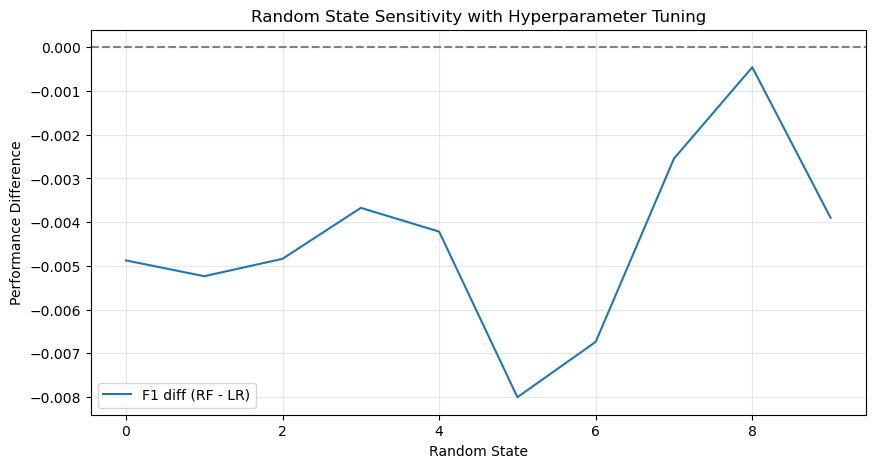

In [22]:

num_states = 10   # repetition
test_size = 0.2
cv = StratifiedKFold(n_splits=5, shuffle=True)
scoring = 'f1'    

# hyperparameters pipeline
rf_param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

lr_param_grid = {
    'model__C': [0.01, 0.1, 1],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
}

# saving the result
results = []

for seed in range(num_states):
    print(f"\n Running random_state = {seed}")
    
    # data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X_dum, y_dum, test_size=test_size, random_state=seed, stratify=y_dum
    )
    
    # Logistic Regression + Scaling
    lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])
    lr_search = GridSearchCV(
        lr_pipe, lr_param_grid, cv=cv, scoring=scoring, n_jobs=-1
    )
    lr_search.fit(X_train, y_train)
    best_lr = lr_search.best_estimator_
    y_pred_lr = best_lr.predict(X_test)
    y_prob_lr = best_lr.predict_proba(X_test)[:, 1]
    
    # Random Forest
    rf_pipe = Pipeline([
        ('model', RandomForestClassifier(class_weight='balanced', random_state=seed))
    ])
    rf_search = GridSearchCV(
        rf_pipe, rf_param_grid, cv=cv, scoring=scoring, n_jobs=-1
    )
    rf_search.fit(X_train, y_train)
    best_rf = rf_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
    
    # metrics
    metrics = {}
    for name, y_pred, y_prob in [
        ('rf', y_pred_rf, y_prob_rf),
        ('lr', y_pred_lr, y_prob_lr)
    ]:
        metrics[name+'_acc'] = accuracy_score(y_test, y_pred)
        metrics[name+'_f1'] = f1_score(y_test, y_pred)
        metrics[name+'_auc'] = roc_auc_score(y_test, y_prob)
    
    # saving the result
    results.append({
        'random_state': seed,
        'rf_best_params': rf_search.best_params_,
        'lr_best_params': lr_search.best_params_,
        **metrics,
        'acc_diff': metrics['rf_acc'] - metrics['lr_acc'],
        'f1_diff': metrics['rf_f1'] - metrics['lr_f1'],
        'auc_diff': metrics['rf_auc'] - metrics['lr_auc']
    })

# transform into DataFrame
results_df = pd.DataFrame(results)

# result
print("\n mean difference")
print(results_df[['acc_diff', 'f1_diff', 'auc_diff']].describe())

# find the seed that differs the most
print("\n🔹 RandomForest performs better random_state:")
print(results_df.sort_values('f1_diff', ascending=False).head(5)[['random_state', 'rf_f1', 'lr_f1', 'f1_diff']])

print("\n🔹 LogisticRegression performs better random_state:")
print(results_df.sort_values('f1_diff', ascending=True).head(5)[['random_state', 'rf_f1', 'lr_f1', 'f1_diff']])

# visualize
plt.figure(figsize=(10,5))
plt.plot(results_df['random_state'], results_df['f1_diff'], label='F1 diff (RF - LR)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Random State')
plt.ylabel('Performance Difference')
plt.title('Random State Sensitivity with Hyperparameter Tuning')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


/var/folders/p8/dwxpbx8970122_rklfr1jfjh0000gn/T/ipykernel_10420/1048355782.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='F1_Score', data=f1_long, palette='Set2')


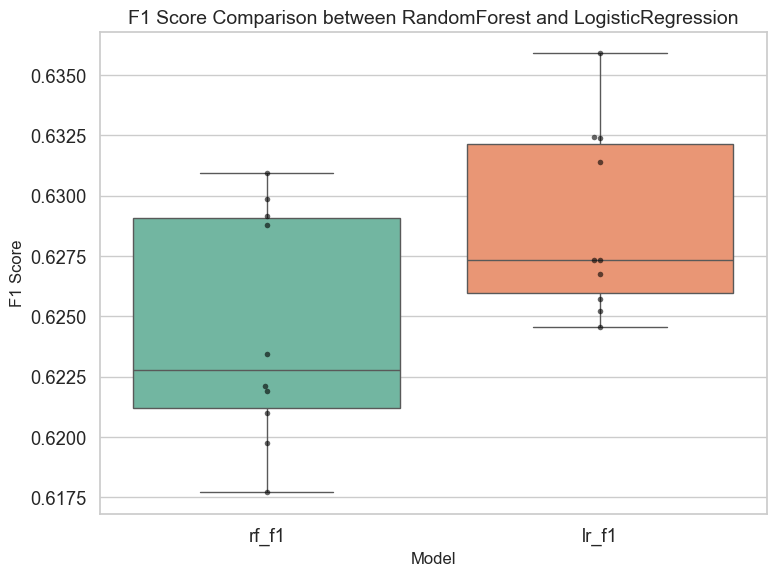

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


f1_data = results_df[['rf_f1', 'lr_f1']]

#transformation for usage of seaborn
f1_long = f1_data.melt(var_name='Model', value_name='F1_Score')


sns.set(style="whitegrid", font_scale=1.2)


plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='F1_Score', data=f1_long, palette='Set2')
sns.swarmplot(x='Model', y='F1_Score', data=f1_long, color='black', alpha=0.6, size=4)


plt.title('F1 Score Comparison between RandomForest and LogisticRegression', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.tight_layout()

plt.show()


In [24]:

rf_params_df = results_df[['rf_best_params', 'rf_f1']].copy()
rf_params_df['rf_best_params'] = rf_params_df['rf_best_params'].astype(str)
rf_summary = rf_params_df.groupby('rf_best_params')['rf_f1'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

print("RandomForest parameters（mean F1）:")
print(rf_summary.head(5))


lr_params_df = results_df[['lr_best_params', 'lr_f1']].copy()
lr_params_df['lr_best_params'] = lr_params_df['lr_best_params'].astype(str)
lr_summary = lr_params_df.groupby('lr_best_params')['lr_f1'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

print("\nLogisticRegression parameters(mean F1）:")
print(lr_summary.head(5))



RandomForest parameters（mean F1）:
                                                        mean       std  count
rf_best_params                                                               
{'model__max_depth': 10, 'model__min_samples_le...  0.629157       NaN      1
{'model__max_depth': 10, 'model__min_samples_le...  0.628769       NaN      1
{'model__max_depth': 10, 'model__min_samples_le...  0.626406  0.006395      2
{'model__max_depth': 10, 'model__min_samples_le...  0.623776  0.008577      2
{'model__max_depth': 10, 'model__min_samples_le...  0.622099       NaN      1

LogisticRegression parameters(mean F1）:
                                                        mean       std  count
lr_best_params                                                               
{'model__C': 0.01, 'model__penalty': 'l2', 'mod...  0.631386       NaN      1
{'model__C': 1, 'model__penalty': 'l2', 'model_...  0.628994  0.004487      7
{'model__C': 0.1, 'model__penalty': 'l2', 'mode...  0.627333  0.000

/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Baseline performance:
Accuracy: 0.6641767573517848
F1: 0.6276697759567605
AUC: 0.7227037582798219


array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER_M'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>],
       [<Axes: xlabel='GENDER_M'>, <Axes: xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>]], dtype=object)

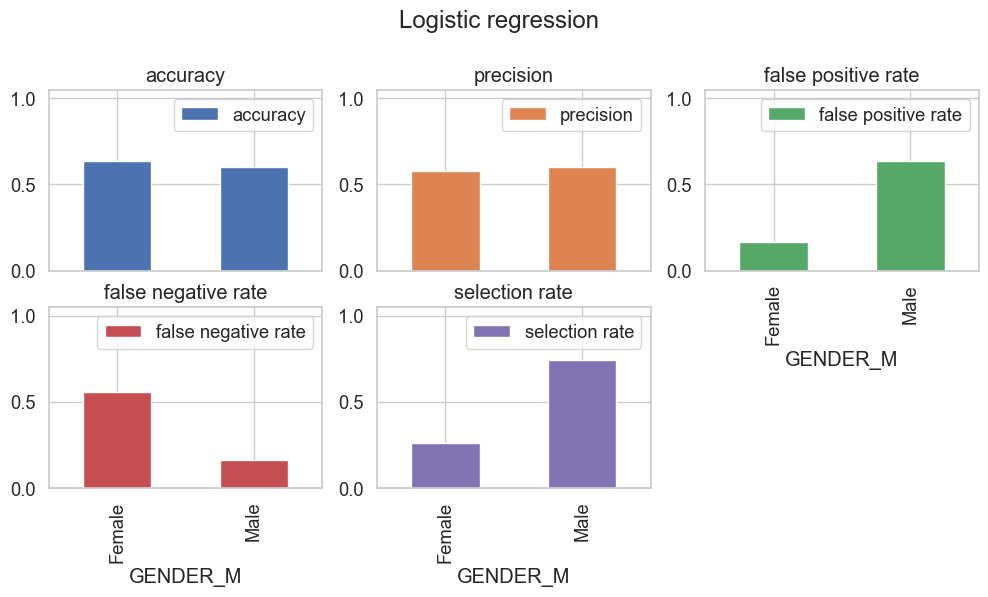

In [25]:
#Fairness evaluation

#Best logistic regression model

pipeline_logic = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(C =0.01, penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42))
])
pipeline_logic.fit(X_train, y_train)

y_pred = pipeline_logic.predict(X_test)
y_prob = pipeline_logic.predict_proba(X_test)[:, 1]

print("Baseline performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

sensitive_test = X_test['GENDER_M']
sensitive_test_named = sensitive_test.replace({False: 'Female', True: 'Male'})
#Plot


metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test_named
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=True,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Logistic regression",
)



/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



CorrelationRemover model performance:
Accuracy: 0.6416103160874351
F1: 0.6048205306051674
AUC: 0.6893168575901616

CorrelationRemover model fairness metrics:
Demographic Parity Difference: 0.009362457392952939
Equalized Odds Difference: 0.07179372480342294


array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER_M'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>],
       [<Axes: xlabel='GENDER_M'>, <Axes: xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>]], dtype=object)

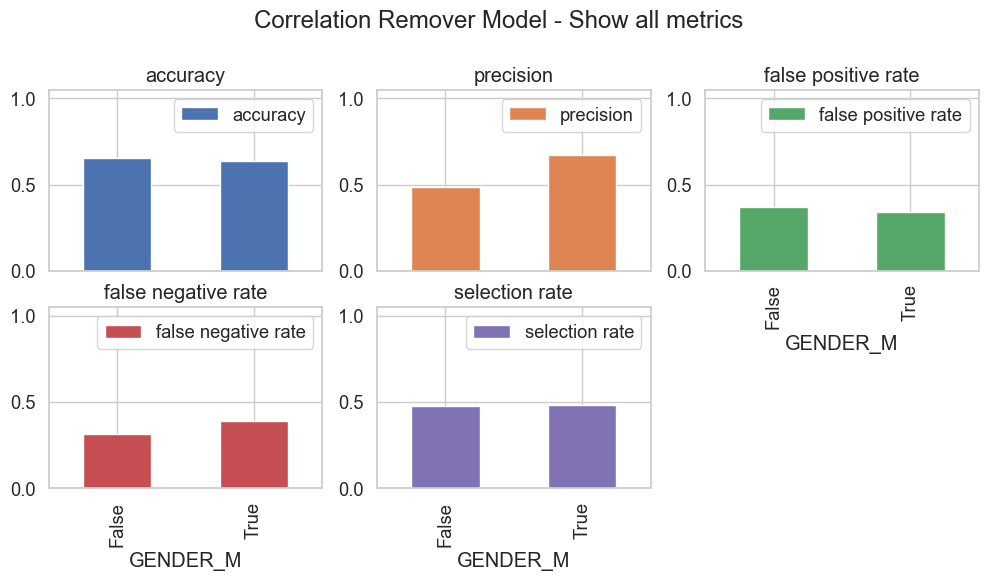

In [26]:
from fairlearn.preprocessing import CorrelationRemover

# get gender_m from X_train
sensitive_train = X_train["GENDER_M"]
sensitive_test = X_test["GENDER_M"]


# initialize correlation remover
corr_remover = CorrelationRemover(
    sensitive_feature_ids=['GENDER_M'], 
    alpha=1.0
) # alpha=1.0 fully removes linear correlation with sensitive feature

# fit on training set
corr_remover.fit(X_train)

# transform training and test sets
X_train_transformed = corr_remover.transform(X_train)
X_test_transformed = corr_remover.transform(X_test)

# model (no sample weights anymore)
reweighted_model = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(
        C=0.01,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

# train
reweighted_model.fit(X_train_transformed, y_train)

# predictions
y_pred_reweighted = reweighted_model.predict(X_test_transformed)
y_prob_reweighted = reweighted_model.predict_proba(X_test_transformed)[:, 1]

# compute metrics
reweighted_accuracy = accuracy_score(y_test, y_pred_reweighted)
reweighted_f1 = f1_score(y_test, y_pred_reweighted)
reweighted_auc = roc_auc_score(y_test, y_prob_reweighted)

print("\nCorrelationRemover model performance:")
print("Accuracy:", reweighted_accuracy)
print("F1:", reweighted_f1)
print("AUC:", reweighted_auc)

# fairness metrics
reweighted_metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_reweighted,
    sensitive_features=sensitive_test
)

dpd_reweighted = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_reweighted,
    sensitive_features=sensitive_test
)

eod_reweighted = equalized_odds_difference(
    y_true=y_test,
    y_pred=y_pred_reweighted,
    sensitive_features=sensitive_test
)

print("\nCorrelationRemover model fairness metrics:")
print("Demographic Parity Difference:", dpd_reweighted)
print("Equalized Odds Difference:", eod_reweighted)

# plot
reweighted_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=True,
    figsize=[12, 8],
    ylim=[0, 1.05],
    title="Correlation Remover Model - Show all metrics"
)


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://sci


Exponentiated Gradient LR performance:
Accuracy: 0.6482151281648058
F1: 0.611564507727036
AUC: 0.6266254827855413

Exponentiated Gradient fairness metrics:
Demographic Parity Difference: 0.0874589933205479
Equalized Odds Difference: 0.04472760759239808


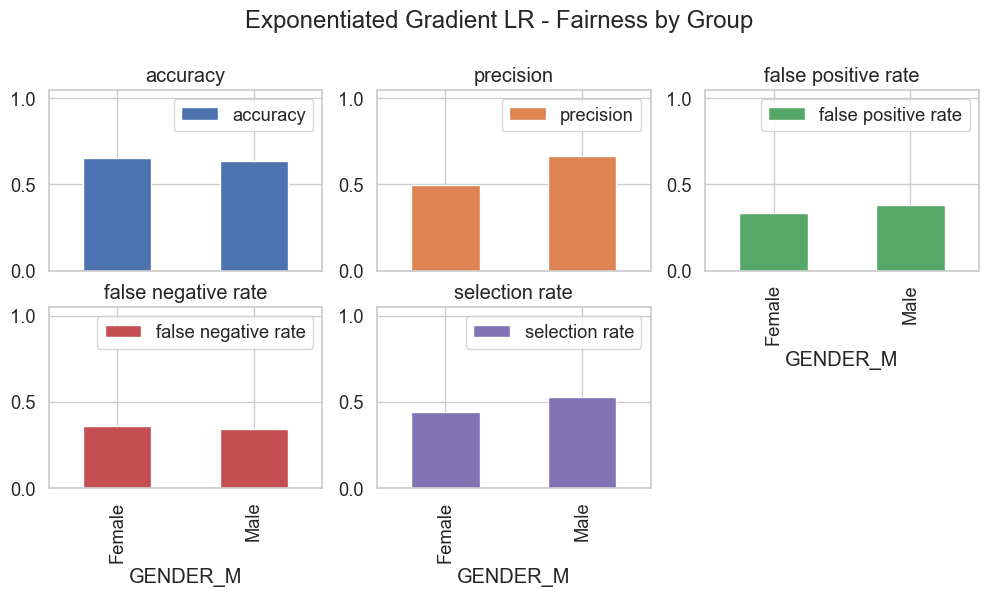

In [27]:
#In processing Exponentiated gradient
#Model
lr_model = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

constraint = EqualizedOdds()   

# Wrap with Exponentiated Gradient
eg_model = ExponentiatedGradient(
    estimator=lr_model,
    constraints=constraint
)

#Training EG model
eg_model.fit(
    X_train,
    y_train,
    sensitive_features=sensitive_train
)

#Predictions
y_pred_eg = eg_model.predict(X_test)

# EG model does not directly expose predict_proba(),
# but we can compute expected probabilities
try:
    y_prob_eg = eg_model.predict_proba(X_test)[:, 1]
except:
    # Backup probability method
    y_prob_eg = np.mean(
        [m.predict_proba(X_test)[:, 1] for m in eg_model.predictors_],
        axis=0
    )

#Performance metrics
eg_accuracy = accuracy_score(y_test, y_pred_eg)
eg_f1 = f1_score(y_test, y_pred_eg)
eg_auc = roc_auc_score(y_test, y_prob_eg)

print("\nExponentiated Gradient LR performance:")
print("Accuracy:", eg_accuracy)
print("F1:", eg_f1)
print("AUC:", eg_auc)

#Fairness metrics

eg_metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_eg,
    sensitive_features=sensitive_test_named
)

demographic_eg = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_eg,
    sensitive_features=sensitive_test_named
)

equalizedodd_eg = equalized_odds_difference(
    y_true=y_test,
    y_pred=y_pred_eg,
    sensitive_features=sensitive_test_named
)

print("\nExponentiated Gradient fairness metrics:")
print("Demographic Parity Difference:", demographic_eg)
print("Equalized Odds Difference:", equalizedodd_eg)

#Plot

eg_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=True,
    figsize=[12, 8],
    ylim=[0, 1.05],
    title="Exponentiated Gradient LR - Fairness by Group"
)
plt.show()


/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nightsky/miniforge3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ThresholdOptimizer Performance:
Accuracy: 0.6414530586570215
F1: 0.5967456667845773


array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER_M'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>],
       [<Axes: xlabel='GENDER_M'>, <Axes: xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>]], dtype=object)

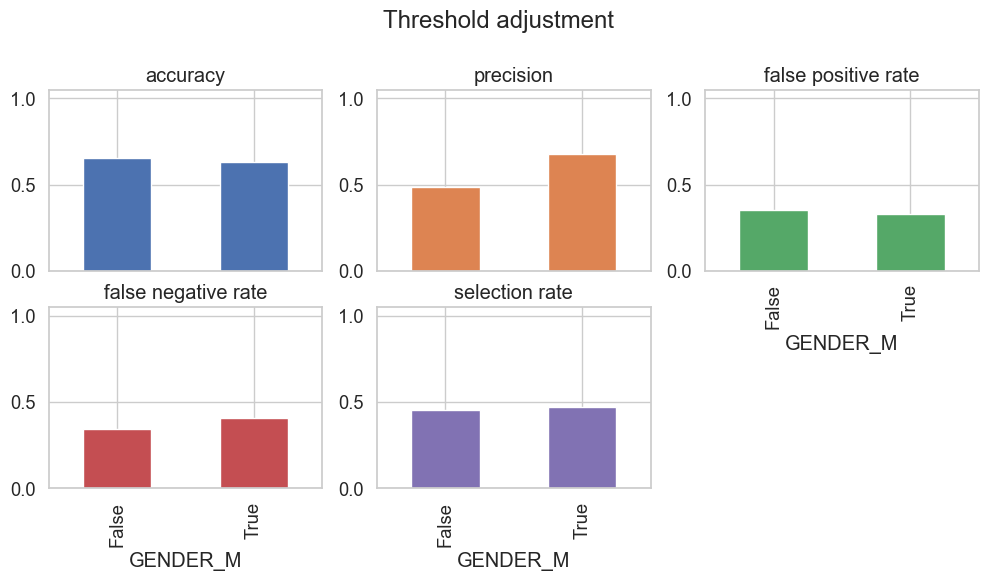

In [28]:

#Postprocessing: Threshold adjustment
#Training



lr_model.fit(X_train,y_train)
TO_model = ThresholdOptimizer(
    estimator=lr_model,
    objective="balanced_accuracy_score",                
    constraints="demographic_parity",          
)

TO_model.fit(X_train, y_train, sensitive_features=sensitive_train)

#Prediction

y_pred_TO = TO_model.predict(
    X_test,
    sensitive_features=sensitive_test
)


#Performance metrics

post_acc = accuracy_score(y_test, y_pred_TO)
post_f1 = f1_score(y_test, y_pred_TO)


print("\nThresholdOptimizer Performance:")
print("Accuracy:", post_acc)
print("F1:", post_f1)

#Fairness metrics

# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred_TO, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Threshold adjustment",
)




In [29]:

print(y_train)

        STEM
26989  False
24309  False
15302  False
27137   True
31416  False
...      ...
33274  False
13920   True
62347  False
6445   False
62433  False

[50869 rows x 1 columns]



=== Global Explanation: Permutation Importance on EG model ===
                         feature  importance       std
3                     MATH_SCORE    0.105588  0.003083
0          NATURAL_SCIENCE_SCORE    0.096047  0.003172
2                  READING_SCORE    0.012932  0.002609
4           SOCIAL_SCIENCE_SCORE    0.009281  0.002477
24         PEOPLE_AT_HOME_5 or 6    0.001623  0.000851
21         FAMILY_INCOME_LEVEL_6    0.001140  0.000872
9              SCHOOL_CALENDAR_B    0.001096  0.001153
23         PEOPLE_AT_HOME_3 or 4    0.000678  0.000712
16  PARENTS_EDUCATION_Vocational    0.000554  0.001448
6               BILINGUAL_SCHOOL    0.000504  0.000961
12     PARENTS_EDUCATION_Primary    0.000442  0.001463
13   PARENTS_EDUCATION_Secondary   -0.000038  0.001202
25             PEOPLE_AT_HOME_7+   -0.000383  0.000454
1                  ENGLISH_SCORE   -0.000461  0.000859
17         FAMILY_INCOME_LEVEL_2   -0.000540  0.000518
8            HAS_INTERNET_ACCESS   -0.000648  0.001173
1

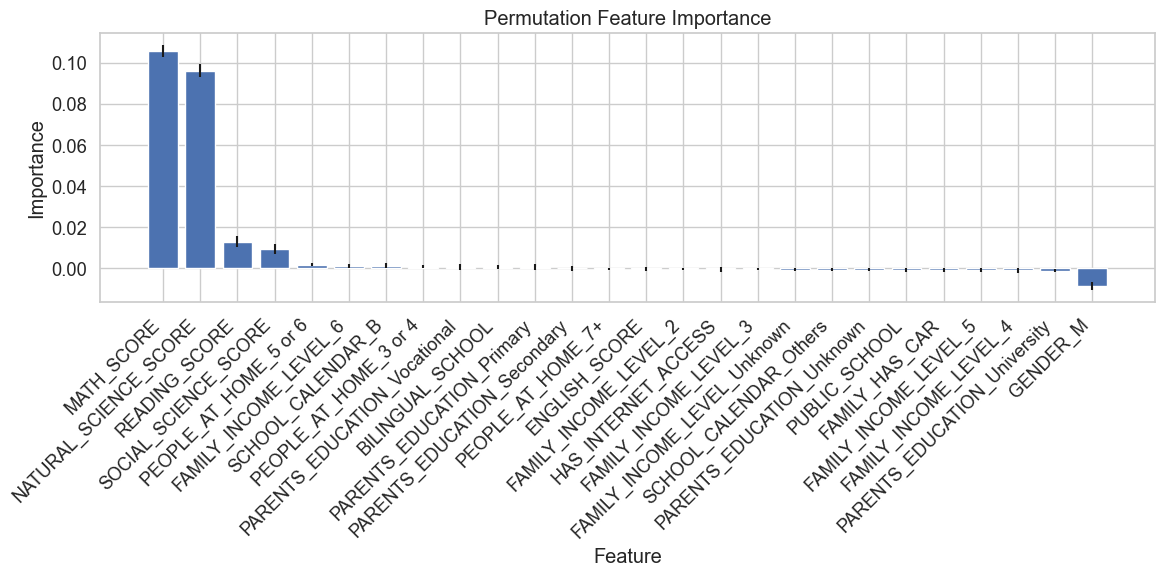

In [30]:
# Global model explanation: Permutation importance



print("\n=== Global Explanation: Permutation Importance on EG model ===")

perm_result = permutation_importance(
    eg_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="f1"
)

perm_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": perm_result.importances_mean,
    "std": perm_result.importances_std
}).sort_values("importance", ascending=False)

print(perm_importance)

plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.bar(perm_importance['feature'], perm_importance['importance'], yerr=perm_importance['std'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:

X_train_nosensitive = X_train.drop(columns=["GENDER_M"])
X_test_nosensitive = X_test.drop(columns=["GENDER_M"])




X_train_transformed = pd.DataFrame(
    corr_remover.transform(X_train),
    columns=X_train_nosensitive.columns
)

X_test_transformed = pd.DataFrame(
    corr_remover.transform(X_test),
    columns=X_test_nosensitive.columns
)


# The kernel explainer receives the function that predicts the probability of classes and the train set as its main inputs.
explainer = shap.KernelExplainer(reweighted_model.predict_proba, X_train_transformed.sample(200))

# Computing the SHAP values using the samples in the test set.
shap_values = explainer(X_test_transformed)

# get just the explanations for the positive class
shap_values = shap_values[..., 1]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 12718/12718 [10:54<00:00, 19.44it/s]


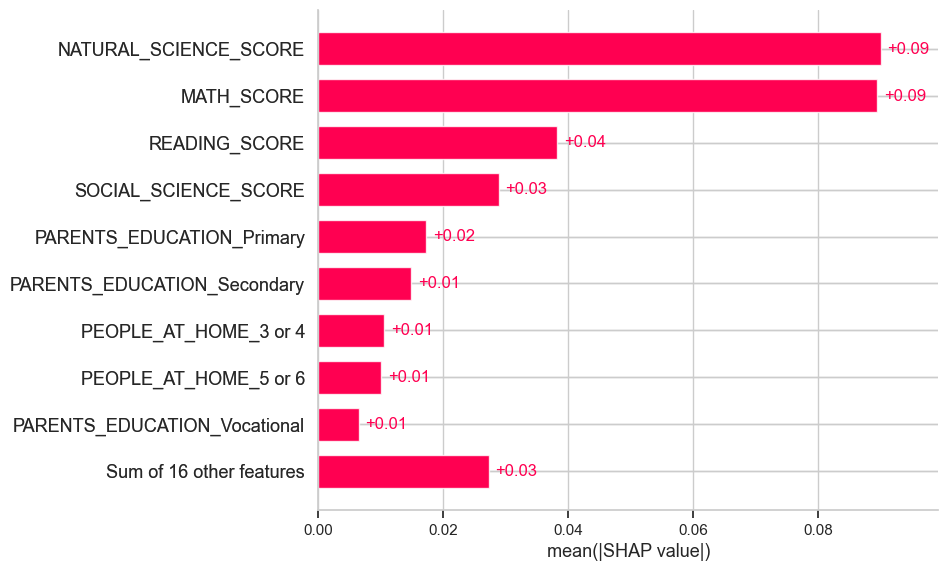

In [41]:
shap.plots.bar(shap_values)

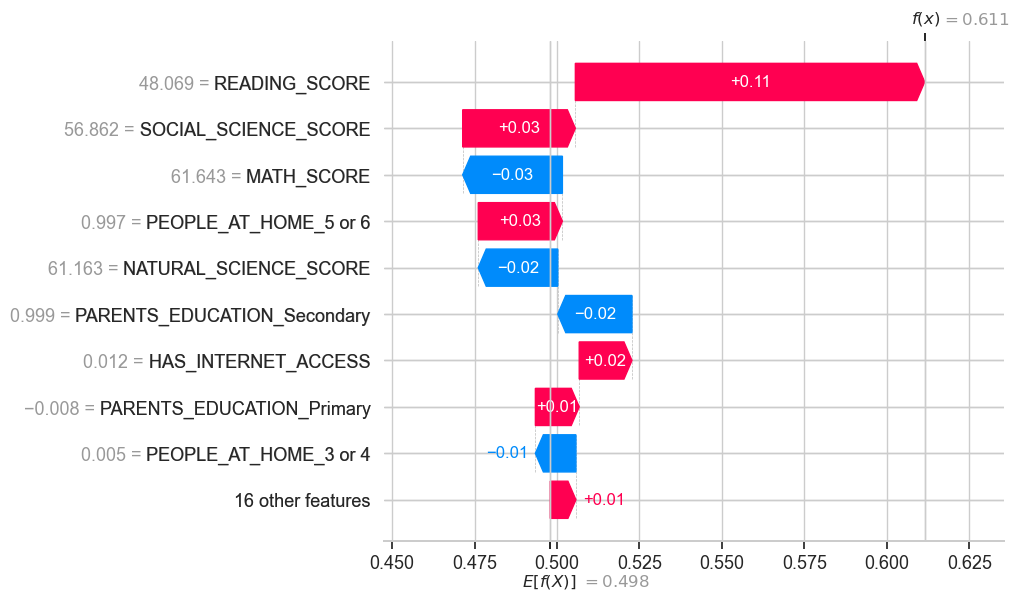

In [42]:
sample_id = 0
shap.plots.waterfall(shap_values[sample_id])